In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db=mysql.connector.connect(host='localhost', username='root', password='12345', database='ecommerce')
cur=db.cursor()

**list of all unique cities where customers are located**

In [3]:
query='''select distinct customer_city from customers'''
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=['cities'])
df.head()

,cities
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


**Count the number of orders placed in 2017**

In [4]:
query='''select count(order_id) from orders where year(order_purchase_timestamp)=2017'''
cur.execute(query)
data=cur.fetchall()
data[0][0]

45101

**Find Total sales per category**

In [5]:
query='''select products.product_category category, 
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category
'''
cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data, columns=['Category','Sales'])
df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


**Calculate the percentage of orders that were paid in installments**

In [6]:
query='''select 
(sum(case when payment_installments>=1 then 1 else 0 end))/count(*)*100
from payments'''
cur.execute(query)
data=cur.fetchall()
data[0][0]

Decimal('99.9981')

**Count the number of customers from each state**

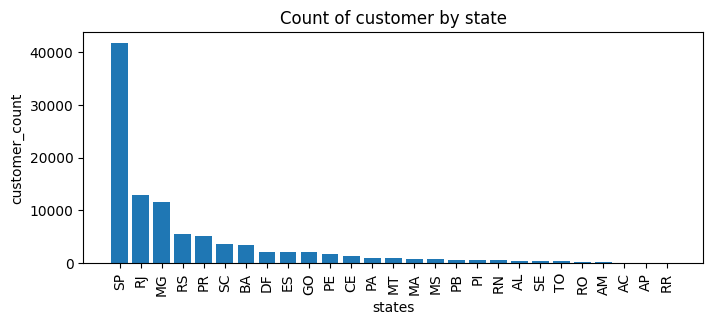

In [18]:
query='''
select customer_state, count(customer_id)
from customers
group by customer_state
'''
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=['State', 'Customer_Count'])
df=df.sort_values(by='Customer_Count', ascending=False)

plt.figure(figsize=(8,3))
plt.bar(df['State'], df['Customer_Count'])
plt.xticks(rotation=90)
plt.xlabel('states')
plt.ylabel('customer_count')
plt.title('Count of customer by state')
plt.show()


**Calculate the number of orders per month in 2018**

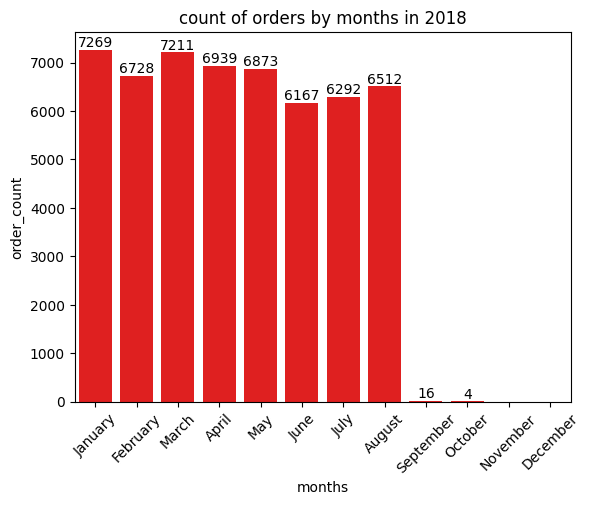

In [21]:
query='''
select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp)=2018
group by months
'''
cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data, columns=['months', 'order_count'])
o=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August','September', 'October', 'November', 'December']

ax=sns.barplot(x=df['months'],y=df['order_count'], data=df, order=o, color='red')
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title('count of orders by months in 2018')
plt.show()

**Find the average number of products per order, grouped by customer city**

In [34]:
query='''
with count_per_order as
(select orders.order_id, orders.customer_id,
count(order_items.order_id) as oc
from orders join order_items
on orders.order_id=order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) as avg_order
from customers join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city
order by avg_order desc

'''
cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data, columns=['customer_city', 'avg_products/order'])
df.head(10)

,customer_city,avg_products/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


**Calculate the percentage of total revenue contributed by each product category**

In [41]:
query='''select upper(products.product_category) category, 
round(sum(payments.payment_value)/(select sum(payment_value) from payments)*100,2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category
order by sales desc
'''
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=['category', 'sales_percentage'])

df.head()

,category,sales_percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


**Identify the correlation between product price and the number of times a product has been purchased**

In [47]:
query='''
select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id=order_items.product_id
group by products.product_category
'''
cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data, columns=['category', 'order_count', 'price'])

import numpy as np

arr1=df['order_count']
arr2=df['price']

np.corrcoef([arr1, arr2])[0][1]


-0.10631514167157562

**Find revenue of each seller and rank them**

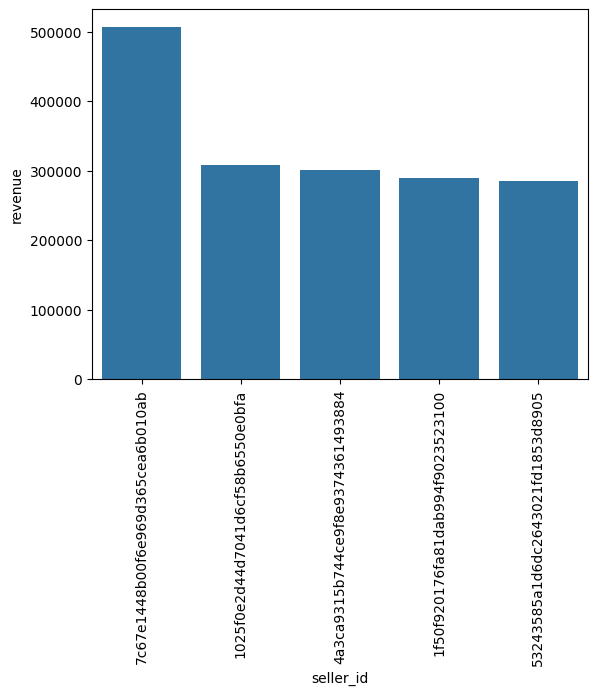

In [59]:
query='''select *, dense_rank() over (order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id=payments.order_id
group by order_items.seller_id) as a
'''
cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data, columns=['seller_id', 'revenue', 'rank'])
df=df.head()
sns.barplot(x='seller_id', y='revenue', data=df)
plt.xticks(rotation=90)
plt.show()

**Calculate the moving average of order values for each custommer over their history**

In [66]:
query='''
select customer_id, order_purchase_timestamp, payment,
avg(payment) over (partition by customer_id order by 
order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id=orders.order_id) as a
'''
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=['customer_id', 'date_&_time', 'price', 'mov_avg'])
df

,customer_id,date_&_time,price,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


**cumulative sales per month for each year**

In [69]:
query='''
select years, months, payment, sum(payment)
over(order by years, months) as cum_sales
from
(select year(orders.order_purchase_timestamp) as years, 
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months
order by years, months) as a
'''
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=['year', 'month', 'sales', 'cum_sales'])
df.head()

,year,month,sales,cum_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


**Calculate the year over year growth rate of total sales**

In [79]:
query='''
with a as(select year(orders.order_purchase_timestamp) as years, 
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years
order by years)
select years, 
round((payment - lag(payment,1) over (order by years))/lag(payment,1) over (order by years)*100,2) from a
'''
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=['year','growth_yoy'])
df

,year,growth_yoy
0,2016,NaN
1,2017,12112.7
2,2018,20.0


**Calculate the retention rate of customers**

In [86]:
query='''
with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id 
'''
cur.execute(query)
data=cur.fetchall()
data

[(None,)]

**Identify the top 3 customers who spent the most money in each year**

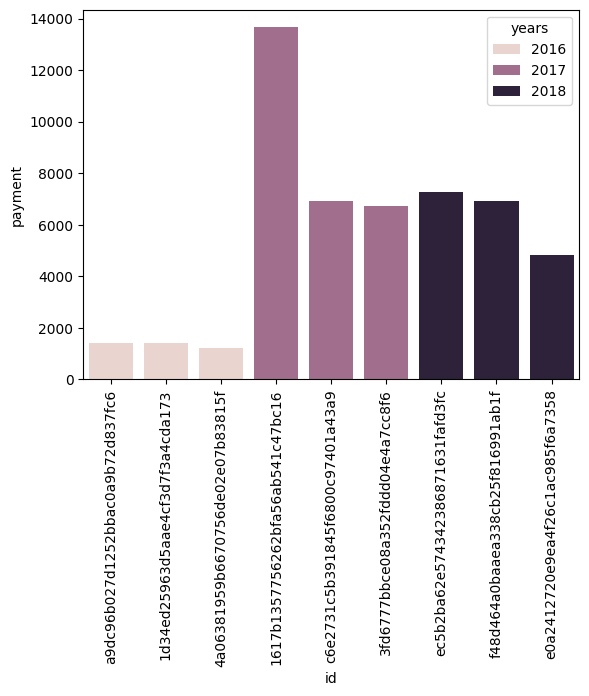

In [90]:
query = """
select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()